In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.rcParams["axes.labelsize"] = 14
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import sklearn.decomposition
from pyriemann.utils.mean import mean_covariance
import pickle
from sklearn.metrics import confusion_matrix

In [50]:
def pca_recon(FC, pctComp=None):
    '''
    Reconstructs FC based on number of principle components
    '''
    if pctComp is None:
        return FC
    nRegions = FC.shape[1]
    FC = np.reshape(FC, (FC.shape[0], -1))
    nComp = int(FC.shape[0] * pctComp)
    mu = np.mean(FC, axis=0)
    pca_rest = sklearn.decomposition.PCA()
    pca_rest.fit(FC)
    cumsum = np.cumsum(pca_rest.explained_variance_ratio_)
    SCORES = pca_rest.transform(FC)[:, :nComp]
    COEFFS = pca_rest.components_[:nComp, :]
    FC_recon = np.dot(SCORES, COEFFS)
    del SCORES, COEFFS
    FC_recon += mu
    FC_recon = np.reshape(FC_recon, (FC.shape[0], nRegions, nRegions))
    return FC_recon, cumsum

def tangential(all_FC, ref):
    # Regularization for riemann
    if ref in ['riemann', 'kullback_sym', 'logeuclid']:
        print("Adding regularization!")
        eye_mat = np.eye(all_FC.shape[1])
        scaling_mat = np.repeat(eye_mat[None, ...], all_FC.shape[0], axis=0)
        all_FC += scaling_mat
    Cg = mean_covariance(all_FC, metric=ref)
    Q1_inv_sqrt = q1invm(Cg)
    Q = Q1_inv_sqrt @ all_FC @ Q1_inv_sqrt
    tangent_FC = np.array([qlog(a) for a in Q])
    return tangent_FC

def q1invm(q1, eig_thresh=0):
    U, S, V = scipy.linalg.svd(q1)
    s = np.diag(S)
    s[s < eig_thresh] = eig_thresh
    S = np.diag(s ** (-1 / 2))
    Q1_inv_sqrt = U * S * np.transpose(V)
    Q1_inv_sqrt = (Q1_inv_sqrt + np.transpose(Q1_inv_sqrt)) / 2
    return Q1_inv_sqrt


def qlog(q):
    U, S, V = scipy.linalg.svd(q)
    s = np.diag(S)
    S = np.diag(np.log(s))
    Q = U * S * np.transpose(V)
    return Q


def get_glasser():
    '''
    Navigates through file tree and extracts FCs with optional reconstruction
    '''
    # Yeo ordering
    fname = '../data/100_unrelated.csv'
    yeo = True
    if yeo:
        yeo_order = list(sio.loadmat("../data/yeo_RS7_N374.mat",
                                     squeeze_me=True,
                                     struct_as_record=False)['yeoOrder'] - 1)
    # Load subject ID and task names
    subjectids = np.loadtxt(fname, dtype=np.int)
    nSubj = len(subjectids)
    tasks = ['rfMRI_REST1_LR', 'rfMRI_REST1_RL', 'rfMRI_REST2_LR',
             'rfMRI_REST2_RL', 'tfMRI_EMOTION_LR', 'tfMRI_EMOTION_RL',
             'tfMRI_GAMBLING_LR', 'tfMRI_GAMBLING_RL', 'tfMRI_LANGUAGE_LR',
             'tfMRI_LANGUAGE_RL', 'tfMRI_MOTOR_LR', 'tfMRI_MOTOR_RL',
             'tfMRI_RELATIONAL_LR', 'tfMRI_RELATIONAL_RL', 'tfMRI_SOCIAL_LR',
             'tfMRI_SOCIAL_RL', 'tfMRI_WM_LR', 'tfMRI_WM_RL']
    M = {}
    # Walk through file tree and extract FCs
    for task in tasks:
        masterFC_dir = '../data/results_SIFT2'
        restingstatename = 'fMRI/' + task + '/FC/FC_glasser_subc_GS_bp_z.mat'
        task_matrices = []
        for subject in subjectids:
            filename = masterFC_dir + '/' + \
                str(subject) + '/' + restingstatename
            mat = sio.loadmat(filename, squeeze_me=True,
                              struct_as_record=False)
            A_orig = mat['FC']
            if yeo:
                A_orig = A_orig[np.ix_(yeo_order, yeo_order)]
            np.fill_diagonal(A_orig, 1)
            task_matrices.append(A_orig)
        M[task] = np.array(task_matrices)
    test = np.concatenate((M['rfMRI_REST1_LR'], M['tfMRI_EMOTION_LR'],
                           M['tfMRI_GAMBLING_LR'], M['tfMRI_LANGUAGE_LR'],
                           M['tfMRI_MOTOR_LR'], M['tfMRI_RELATIONAL_LR'],
                           M['tfMRI_SOCIAL_LR'], M['tfMRI_WM_LR']))
    retest = np.concatenate((M['rfMRI_REST1_RL'], M['tfMRI_EMOTION_RL'],
                             M['tfMRI_GAMBLING_RL'], M['tfMRI_LANGUAGE_RL'],
                             M['tfMRI_MOTOR_RL'], M['tfMRI_RELATIONAL_RL'],
                             M['tfMRI_SOCIAL_RL'], M['tfMRI_WM_RL']))
    del M
    all_FC = np.concatenate((test, retest))
    del test, retest
    return all_FC, nSubj

def get_schaefer(parc, ref='none'):
    if ref.lower() == 'none':
        with open(f'../data/schaefer{parc}.pickle', 'rb') as f:
            all_FC = pickle.load(f)
    else:
        with open(f'../data/tangent_fcs/schaefer{parc}_{ref}.pickle', 'rb') as f:
            all_FC = pickle.load(f)
    nSubj = int(all_FC.shape[0]/16)
    return all_FC, nSubj

## HCP 100 Subjects CNN with 3 Pipelines

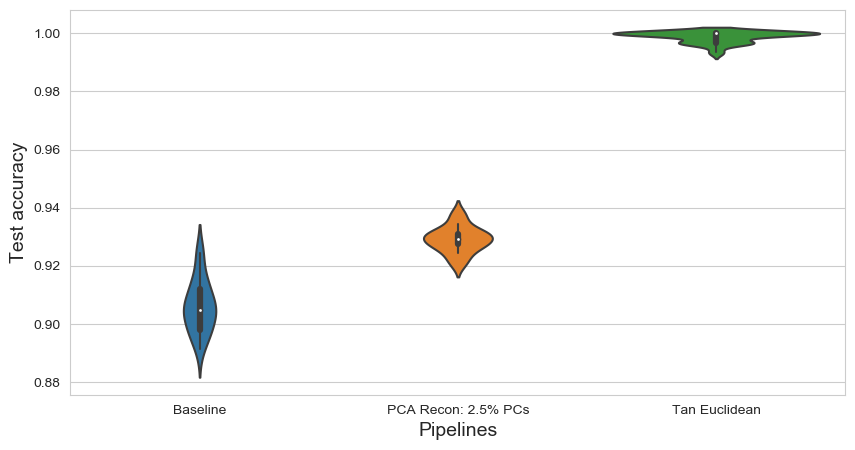

In [51]:
sns.set_style("whitegrid")
baseline = pd.read_csv('HCP100_base_E200_LR0.001_R1_S0_Y1_20.csv')
tan_euclidean = pd.read_csv('HCP100_Taneuclid_E200_LR0.001_R1_S0_Y1_20.csv')
pca_recon = pd.read_csv('HCP100_recon_0.025_E200_LR0.001_R0_S0_Y1.csv')
df = pd.concat([baseline['Accuracy'], pca_recon['Accuracy'],
                tan_euclidean['Accuracy']], axis=1,
               keys=['Baseline', 'PCA Recon: 2.5% PCs', 'Tan Euclidean'])
df = df.melt(var_name='Pipelines', value_name='Test accuracy')
ax = sns.violinplot(x="Pipelines", y="Test accuracy", data=df)
fig = ax.get_figure()
fig.set_size_inches(10,5)
plt.savefig('DL_pipelines.eps', bbox_inches='tight', transparent=True)
plt.show()

## Task Classification on Closest FC without DL

In [54]:
distances = pd.read_csv('distances_tangent.csv', names=["Type", "Accuracy"])
new = distances["Type"].str.rsplit("_", n = 1, expand = True) 
distances['Tangent Reference'] = new[0]
distances['Distance'] = new[1]
distances.drop(columns =["Type"], inplace = True) 
distances.head()

,Accuracy,Tangent Reference,Distance
0,0.807353,none,correlation
1,0.806618,none,cosine
2,0.634559,none,euclidean
3,0.441912,euclid,correlation
4,0.444853,euclid,cosine


<Figure size 640x480 with 0 Axes>

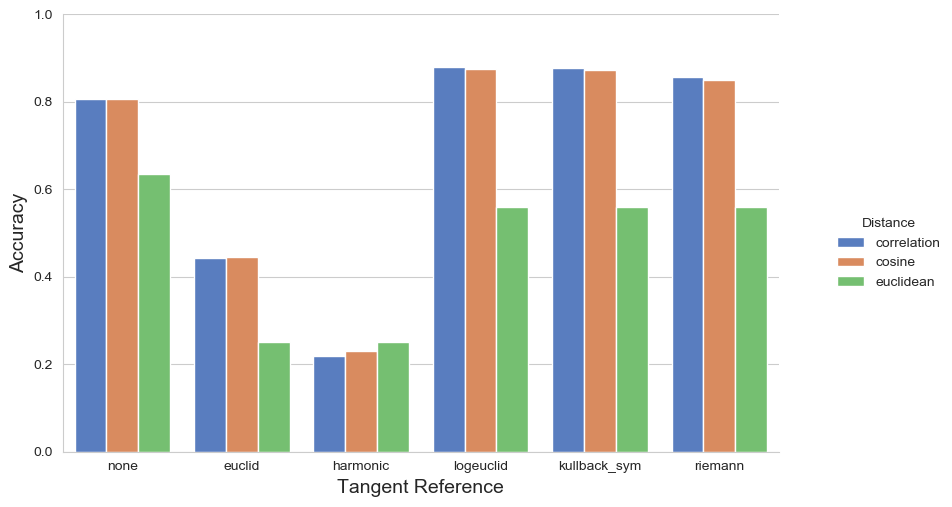

In [56]:
sns.set_style("whitegrid")
plt.tight_layout()
ref_plot = sns.catplot(x="Tangent Reference", y="Accuracy", hue="Distance", data=distances,
                height=6, kind="bar", palette="muted", legend_out=True).set(ylim=(0, 1))
ref_plot.fig.set_size_inches(10,5)
plt.savefig('distance_task.eps', bbox_inches='tight', transparent=True)
plt.show()

## Subject Classification on Closest FC without DL

In [ ]:
distances = pd.read_csv('distances_subject.csv', names=["Type", "Accuracy"])
new = distances["Type"].str.rsplit("_", n = 1, expand = True) 
distances['Tangent Reference'] = new[0]
distances['Distance'] = new[1]
distances.drop(columns =["Type"], inplace = True) 
distances.head()

In [ ]:

plt.tight_layout()
ref_plot = sns.catplot(x="Tangent Reference", y="Accuracy", hue="Distance", data=distances,
                height=6, kind="bar", palette="muted").set(ylim=(0, 1))
#ref_plot.fig.suptitle('HCP100 Subject Classification Accuracy with Closest FC', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('distance_subj.png', bbox_inches='tight')
plt.show()

### KNN Classification, k = 30

In [24]:
knn_distances = pd.read_csv('knn_distances_task.csv', names=["Type", "Accuracy"])
new = knn_distances["Type"].str.rsplit("_", n = 1, expand = True) 
knn_distances['Tangent Reference'] = new[0]
knn_distances['Distance'] = new[1]
knn_distances.drop(columns =["Type"], inplace = True) 
knn_distances.head()

,Accuracy,Tangent Reference,Distance
0,0.868421,euclid,correlation
1,0.848684,euclid,cosine
2,0.125000,euclid,euclidean
3,0.875000,harmonic,correlation
4,0.875000,harmonic,cosine


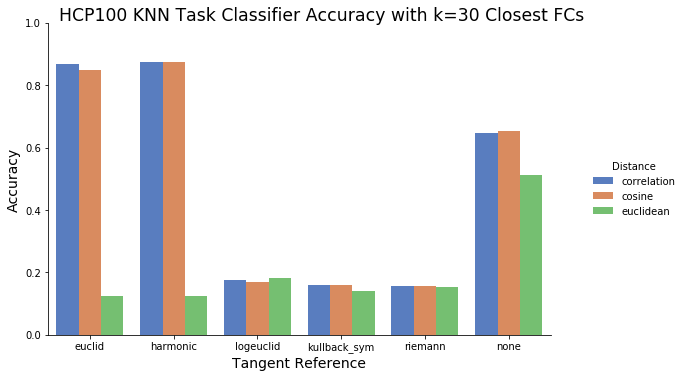

In [25]:
ref_plot = sns.catplot(x="Tangent Reference", y="Accuracy", hue="Distance", data=knn_distances,
                height=6, kind="bar", palette="muted").set(ylim=(0, 1))
ref_plot.fig.suptitle('HCP100 KNN Task Classifier Accuracy with k=30 Closest FCs', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('knn_classification.eps', bbox_inches='tight', transparent=True)
plt.show()

### Subject Classification - KNN 

In [ ]:
knn_subject = pd.read_csv('knn_distances_subject.csv', names=["Type", "Accuracy"])
new = knn_subject["Type"].str.rsplit("_", n = 1, expand = True) 
knn_subject['Tangent Reference'] = new[0]
knn_subject['Distance'] = new[1]
knn_subject.drop(columns =["Type"], inplace = True) 
knn_subject.head()

In [ ]:
ref_plot = sns.catplot(x="Tangent Reference", y="Accuracy", hue="Distance", data=knn_subject,
                height=6, kind="bar", palette="muted").set(ylim=(0, 1))
ref_plot.fig.suptitle('HCP100 Subject Classifier Accuracy with k=30 Closest FCs', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('knn_subj.eps', bbox_inches='tight', transparent=True)
plt.show()

## Schaefer Parcellations

In [ ]:
schaefer = pd.read_csv('schaefer_distances.csv', names=["Type", "Accuracy"])
new = schaefer["Type"].str.rsplit("_", n = 1, expand = True) 
schaefer['Parcellation'] = new[0]
schaefer['Tangent Reference'] = new[1]
schaefer.drop(columns =["Type"], inplace = True) 
schaefer.head()

In [ ]:
ref_plot = sns.catplot(x="Tangent Reference", y="Accuracy", hue="Parcellation", data=schaefer,
                height=6, kind="bar", palette="muted").set(ylim=(0, 1))
ref_plot.fig.suptitle('Schaefer Parcellation Task Classifier Accuracy with k=30 Closest FCs', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('knn_task.eps', bbox_inches='tight', transparent=True)
plt.show()

In [20]:
def utri2mat(utri):
    n = int(-1 + np.sqrt(1 + 8 * len(utri))) // 2
    iu1 = np.tril_indices(n+1,-1)
    ret = np.empty((n+1, n+1))
    ret[iu1] = utri
    ret.T[iu1] = utri
    np.fill_diagonal()
    return ret

In [ ]:
import numpy as np
iu1 = np.triu_indices(5,1)
ret = np.zeros((5,5))
ret[iu1] = np.arange(1,11)
print(ret)
ret = np.zeros((5,5))
iu1 = np.tril_indices(5,-1)
iu2 = (iu1[0][::-1], iu1[1][::-1])
ret[iu1] = np.arange(1,11)
print(ret.transpose())

In [2]:
import pickle
with open('../data/schaefer100.pickle', 'rb') as f:
    all_parc = pickle.load(f)

## Visualize Connectomes

Performing PCA Recon
Performing tangent space projection


/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in power
/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log


(6784, 114, 114)


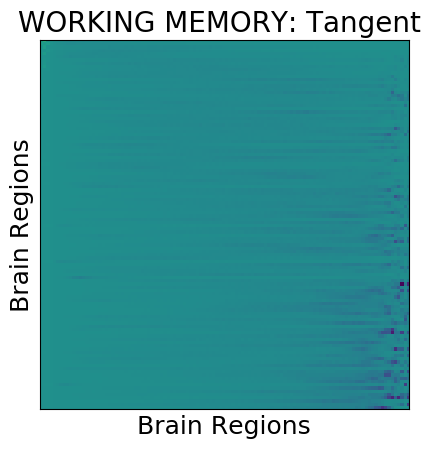

In [28]:
tasks = ['REST', 'EMOTION', 'GAMBLING', 'LANGUAGE', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WORKING MEMORY']
indices = np.arange(0,3816,424)
task_dict = {A: B for A, B in zip(tasks, indices)}
for proc in ['Raw', 'PCA', 'Tangent']:
    all_parc, nSubj = get_schaefer(100)
    if proc == 'PCA':
        print('Performing PCA Recon')
        all_parc, cumsum = pca_recon(all_parc, 0.01)
    elif proc == 'Tangent':
        print('Performing tangent space projection')
        all_parc = tangential(all_parc, 'euclid')
        print(all_parc.shape)
    for idx, task in enumerate(tasks):
        task_mean = np.mean(all_parc[indices[idx]:indices[idx+1]], 0)
        plt.style.use('default')
        plt.imshow(task_mean,origin='lower')
        plt.xticks([], [])
        plt.yticks([],[])
        plt.title(f'{task}: {proc} ', fontdict = {'fontsize' : 20})
        plt.ylabel('Brain Regions',fontdict = {'fontsize' : 18})
        plt.xlabel('Brain Regions',fontdict = {'fontsize' : 18})
        plt.clim(-1, 1)
        plt.savefig(f'Schaefer_avg_{proc}_{task}.eps', bbox_inches='tight', transparent=True)

In [6]:
tasks = ['REST', 'EMOTION', 'GAMBLING', 'LANGUAGE', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WORKING MEMORY']
indices = np.arange(0,2978,424)
task_dict = {A: B for A, B in zip(tasks, indices)}

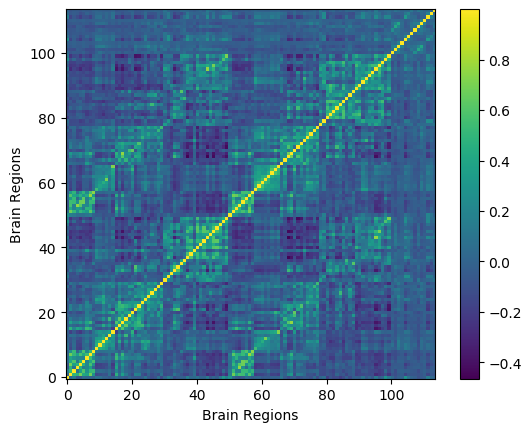

In [35]:
groupFC = np.mean(all_parc, 0)
plt.imshow(groupFC,origin='lower')
plt.colorbar()
plt.ylabel('Brain Regions')
plt.xlabel('Brain Regions')
plt.savefig('group_FC.eps', bbox_inches='tight', transparent=True)
plt.show()

# Tangent Space Connectomes

### Reference Matrices

Importing all correlation matrices... All FCs successfully loaded!

euclid


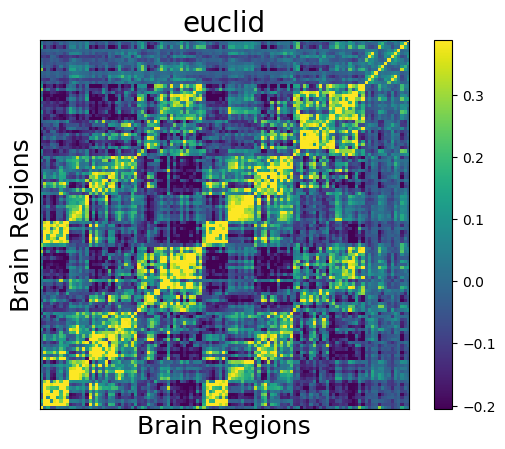

Importing all correlation matrices... All FCs successfully loaded!

kullback_sym
Adding regularization!


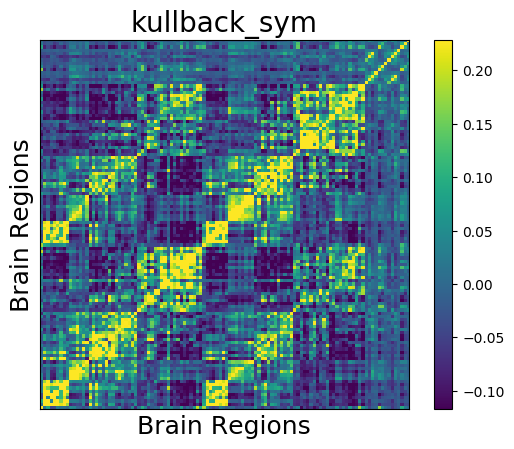

Importing all correlation matrices... All FCs successfully loaded!

harmonic


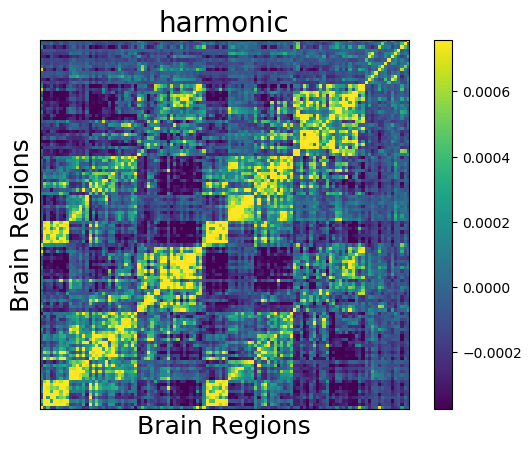

Importing all correlation matrices... All FCs successfully loaded!

logeuclid
Adding regularization!


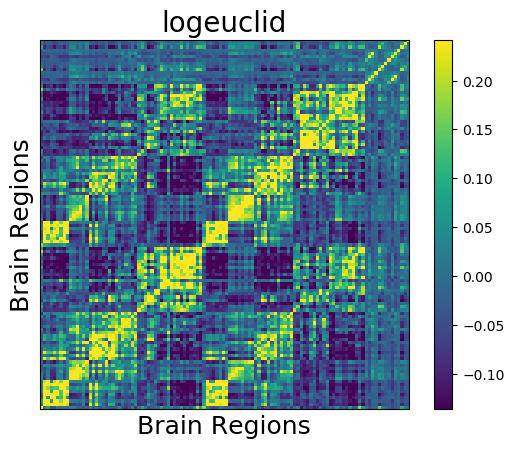

Importing all correlation matrices... All FCs successfully loaded!

riemann
Adding regularization!


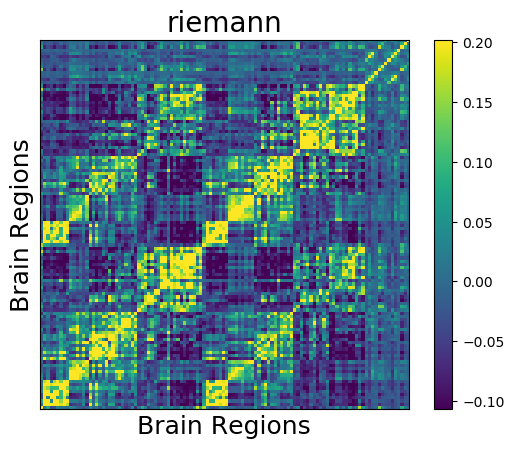

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
for ref in ['euclid', 'kullback_sym', 'harmonic', 'logeuclid', 'riemann']:
    print("Importing all correlation matrices...", end=" ")
    all_FC, nSubj = get_schaefer(100)
    print("All FCs successfully loaded!\n")
    print(ref)
    if ref in ['riemann', 'kullback_sym', 'logeuclid']:
        print("Adding regularization!")
        eye_mat = np.eye(all_FC.shape[1])
        scaling_mat = np.repeat(eye_mat[None, ...], all_FC.shape[0], axis=0)
        all_FC += scaling_mat
    Cg = mean_covariance(all_FC, metric=ref)
    plt.style.use('default')
    sampleFC = Cg
    plt.imshow(sampleFC,origin='lower')
    plt.ylabel('Brain Regions')
    plt.xlabel('Brain Regions')
    plt.colorbar()
    plt.clim(np.percentile(Cg, 5), np.percentile(Cg, 95))
    plt.xticks([], [])
    plt.yticks([],[])
    plt.title(f'{ref}', fontdict = {'fontsize' : 20})
    plt.ylabel('Brain Regions',fontdict = {'fontsize' : 18})
    plt.xlabel('Brain Regions',fontdict = {'fontsize' : 18})
    plt.savefig(f'../results/reference_{ref}.eps', bbox_inches='tight')
    plt.show()

### Tangent Projected

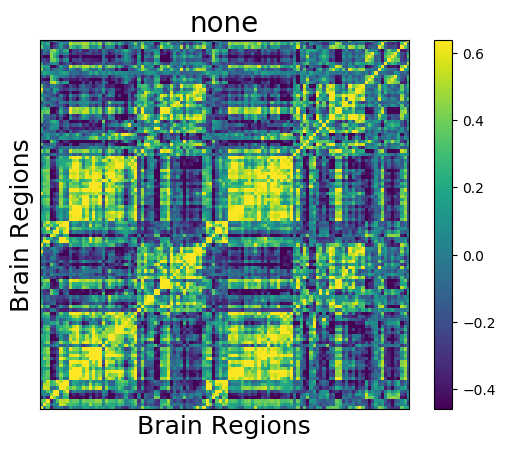

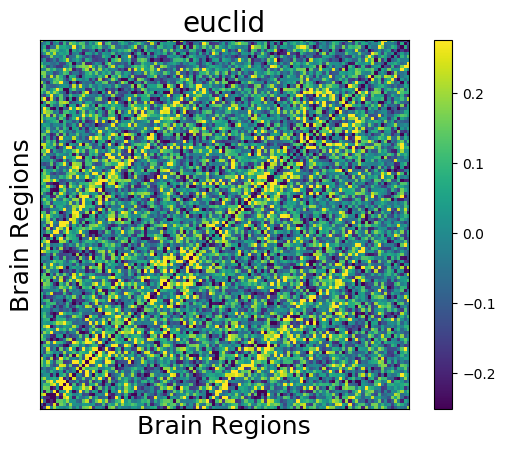

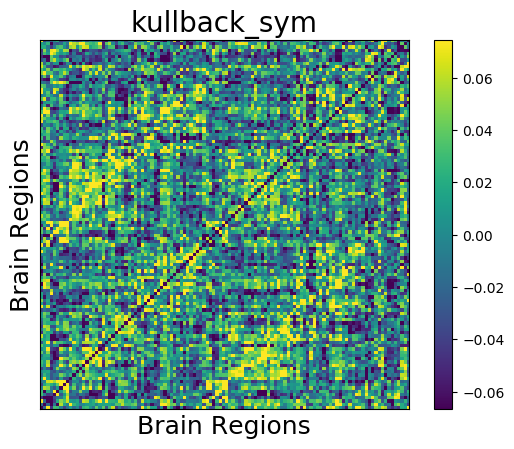

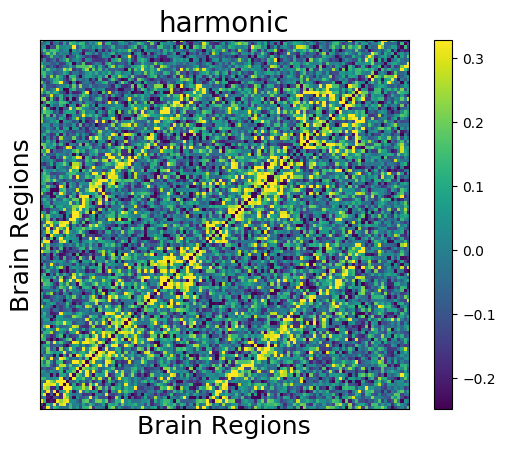

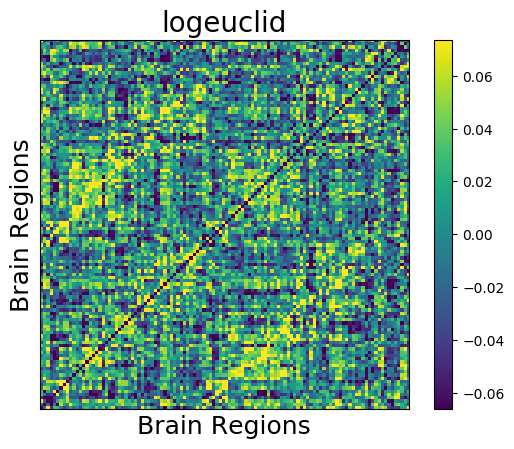

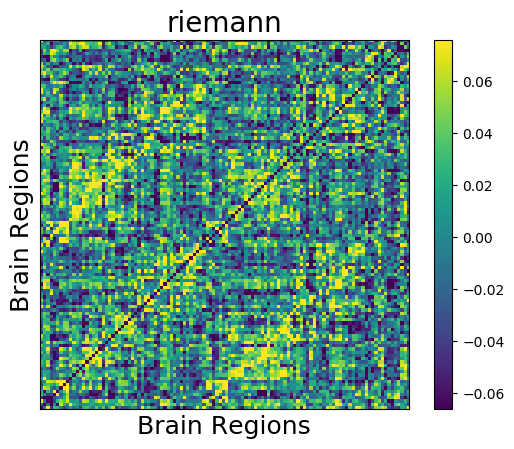

In [48]:
for ref in ['none', 'euclid', 'kullback_sym', 'harmonic', 'logeuclid', 'riemann']:
    all_FC, nSubj = get_schaefer(100, ref)
    plt.style.use('default')
    sampleFC = all_FC[0]
    plt.imshow(sampleFC,origin='lower')
    plt.ylabel('Brain Regions')
    plt.xlabel('Brain Regions')
    plt.colorbar()
    plt.clim(np.percentile(sampleFC, 5), np.percentile(sampleFC, 95))
    plt.xticks([], [])
    plt.yticks([],[])
    plt.title(f'{ref}', fontdict = {'fontsize' : 20})
    plt.ylabel('Brain Regions',fontdict = {'fontsize' : 18})
    plt.xlabel('Brain Regions',fontdict = {'fontsize' : 18})
    plt.savefig(f'../results/projected_{ref}.eps', bbox_inches='tight')
    plt.show()
    

In [ ]:
schaefer_knn = pd.read_csv('schaefer_300_task_float32.csv', names=["Type", "Accuracy"])

In [ ]:
new = schaefer_knn["Type"].str.rsplit("_", n = 1, expand = True) 
new2 = new[0].str.split("_", n = 1, expand = True) 

In [ ]:
schaefer_knn['Parcellation'] = new[1]
schaefer_knn['Tangent Reference'] = new2[1]
schaefer_knn['K'] = new2[0]
schaefer_knn.drop(columns =["Type"], inplace = True) 
#schaefer_knn['K'] = schaefer_knn['K'].replace(['5'], '30')
schaefer_knn['K'] = schaefer_knn['K'].astype(int)

In [ ]:
ref_plot = sns.catplot(x="Tangent Reference", y="Accuracy", hue="K", data=schaefer_knn,
                height=6, kind="bar", palette="muted").set(ylim=(0, 1))
ref_plot.fig.set_size_inches(10,5)
plt.savefig('schaefer_k.eps', bbox_inches='tight', transparent=True)
plt.show()

## Twins

In [29]:
twin_pca = pd.read_csv('twin_pca_optimal.csv', names=["PctComps", "Accuracy"])

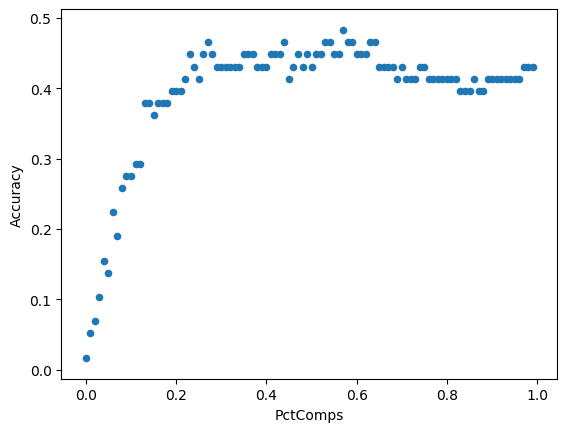

In [37]:
# PCA reconstruction of rest twin components
twin_pca.plot(x='PctComps', y='Accuracy', kind='scatter', )

In [39]:
df = pd.read_csv('MZ_twin_parcellations.csv', names=["First", "Accuracy"])
df['Parcellation'], df['Task'] = df['First'].str.split(':', 1).str
df.drop(['First'], axis=1, inplace=True)
df.round(3)
df = df[['Task', 'Parcellation', 'Accuracy']]

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


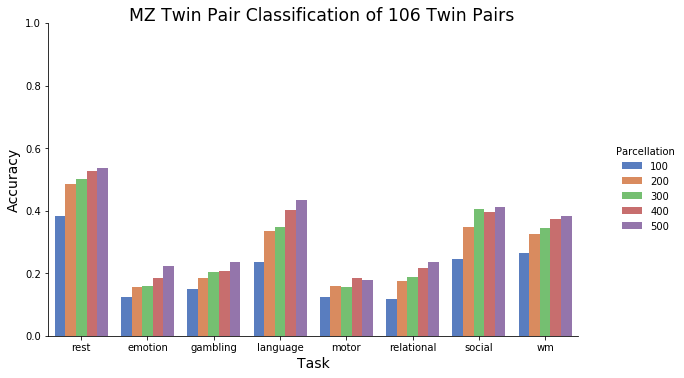

In [40]:
ref_plot = sns.catplot(x="Task", y="Accuracy", hue="Parcellation", data=df,
                height=6, kind="bar", palette="muted").set(ylim=(0, 1))
ref_plot.fig.suptitle('MZ Twin Pair Classification of 106 Twin Pairs', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('MZ_twin_pairs.eps', bbox_inches='tight', transparent=True)
plt.show()

In [41]:
df = pd.read_csv('DZ_twin_parcellations.csv', names=["First", "Accuracy"])
df['Parcellation'], df['Task'] = df['First'].str.split(':', 1).str
df.drop(['First'], axis=1, inplace=True)
df.round(3)
df = df[['Task', 'Parcellation', 'Accuracy']]

/Users/michael/anaconda3/envs/fmri/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


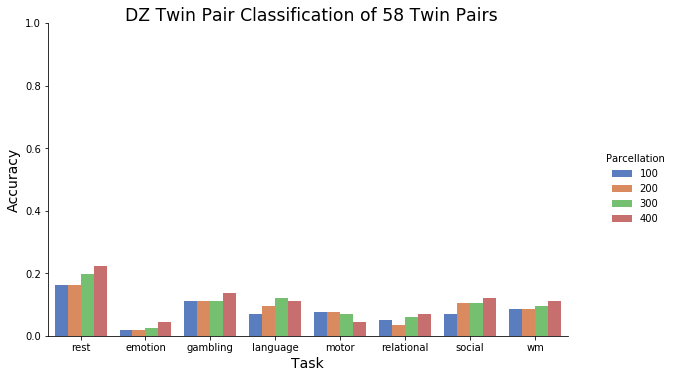

In [42]:
ref_plot = sns.catplot(x="Task", y="Accuracy", hue="Parcellation", data=df,
                height=6, kind="bar", palette="muted").set(ylim=(0, 1))
ref_plot.fig.suptitle('DZ Twin Pair Classification of 58 Twin Pairs', y=1.02, fontsize='xx-large')
ref_plot.fig.set_size_inches(10,5)
plt.savefig('DZ_twin_pairs.eps', bbox_inches='tight', transparent=True)
plt.show()